In [2]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [3]:
import warnings
warnings.simplefilter('ignore', FutureWarning)
from IPython.core.display import HTML
HTML('''<link href='http://fonts.googleapis.com/css?family=Lora:400,700,400i,700i' rel='stylesheet'><link href='https://fonts.googleapis.com/css?family=Lato:300,400,700,300i,400i,700i' rel='stylesheet'><link href='https://fonts.googleapis.com/css?family=Inconsolata:400' rel='stylesheet'><link rel="stylesheet" href="http://maxcdn.bootstrapcdn.com/font-awesome/4.3.0/css/font-awesome.min.css"><style>h1, h2, h3, h4, h5 { font-family: 'Lato', sans-serif; } h5 { font-style: normal; } kbd { font-family: Lato, serif; } hr { border-width: 2px; border-color: #a9a9a9; } .cite { font-size: 85%; text-align: right; margin-top: 10px; } .note { font-family: Lora, serif; font-size: 10pt; font-weight: 400; margin-top: 0; margin-bottom: 0; } h5.prehead { font-family: Lato, serif; font-style: normal; font-size: 14pt; font-weight: 300; margin-bottom: 15px; margin-top: 30px; } h5.lesson { font-family: Lato, serif; font-weight: 400; font-size: 15pt; font-style: normal; margin-top: 0px; margin-bottom: 5px; } h1.lesson_title { font-family: Lato, serif; font-weight: 300; font-size: 32pt; line-height: 110%; color:#CD2305; margin-top: 0px; margin-bottom: 15px; } div.cell{ max-width: 1120px; margin-left: auto; margin-right: auto; } div.text_cell_render { font-family: Lora, serif; line-height: 160%; font-size: 13pt; } .rendered_html pre, .rendered_html code  { font-family: Inconsolata, monospace !important; font-size: 13pt; } div.CodeMirror, div.output_area pre, div.prompt { font-family: Inconsolata, monospace !important; font-size: 125%; } .rendered_html ul li { margin-top: 0.75em; margin-bottom: 0.75em; } .rendered_html ul li ul li { margin-top: 0.5em; margin-bottom: 0.5em; } .rred { color: #a00000; } </style> <script> MathJax.Hub.Config({ TeX: { extensions: ["AMSmath.js"] }, tex2jax: { inlineMath: [ ['$','$'], ["\\(","\\)"] ], displayMath: [ ['$$','$$'], ["\\[","\\]"] ] }, displayAlign: 'center', // Change this to 'center' to center equations. "HTML-CSS": { styles: {'.MathJax_Display': {"margin": "0.75em 0"}} } }); </script>''')

### Regression line vs other lines

In [4]:
demographics = Table.read_table('district_demographics2016.csv').drop('Percent voting for Clinton')
demographics.show(5)

State,District,Median Income,College%
Alabama,"Congressional District 1 (115th Congress), Alabama",47083,24
Alabama,"Congressional District 2 (115th Congress), Alabama",42035,21.8
Alabama,"Congressional District 3 (115th Congress), Alabama",46544,22.8
Alabama,"Congressional District 4 (115th Congress), Alabama",41110,17
Alabama,"Congressional District 5 (115th Congress), Alabama",51690,30.3


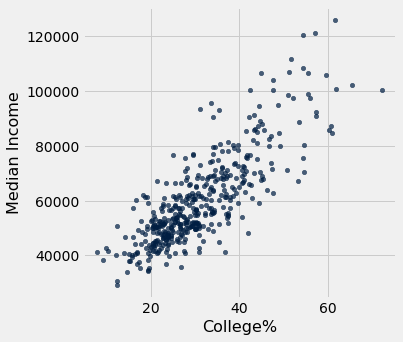

In [5]:
demographics.select('Median Income', 'College%').scatter('College%')

 <font size='4pt'> The `show_demographics_rmse` function: 

* Variables `slope` and `intercept`
* Generates...
    * Scatter plot of `demographics.select('Median Income', 'College%')`
    * Line with the given `slope` and `intercept`
    * Errors from the points [14.7, 33995], [19.1, 61454], [50.7, 71183], [59.5, 105918]
    * Root Mean Squared Error (RMSE)
</font>

In [6]:

def show_demographics_rmse(slope, intercept):
    # Use four convenient points from the original data
    sample = [[14.7, 33995], [19.1, 61454], [50.7, 71183], [59.5, 105918]]
    demographics.scatter('College%', 'Median Income', alpha=0.5)
    xlims = make_array(5, 75)
    # Plot a line with the slope and intercept you specified:
    plots.plot(xlims, slope * xlims + intercept, lw=4)
    # Plot red lines from each of the four points to the line
    for x, y in sample:
        plots.plot([x, x], [y, slope * x + intercept], color='r', lw=4)
    
    #demographics_errors(slope, intercept)
    x = demographics.column('College%')
    y = demographics.column('Median Income')
    prediction = slope * x + intercept
    mse = np.mean((y - prediction) ** 2)
    print("Root mean squared error:", round(mse ** 0.5, 2))
    

Root mean squared error: 38679.82


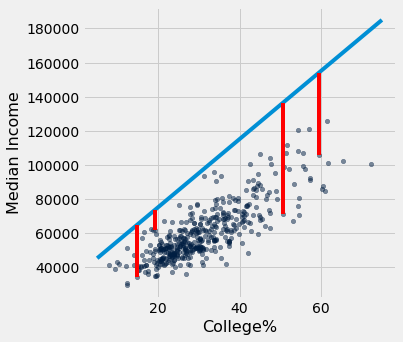

In [7]:
# takes any slope, any intercept

show_demographics_rmse(2000, 35000)

Root mean squared error: 61762.88


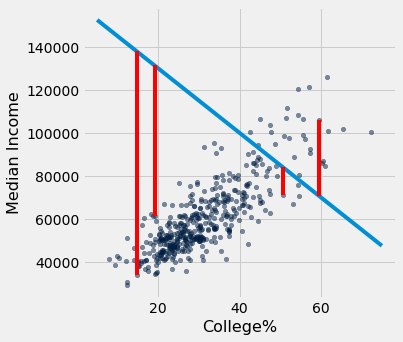

In [8]:
# takes any slope, any intercept

show_demographics_rmse(-1500, 160000)

 <font size='4pt'> Goal: Find values of `slope` and `intercept` that **minimize** RMSE.
</font>

 ### Regression Line:
<font size='4pt'> Standard Units:</font>
 $$ y = r\cdot x \; \; \; \; \; $$
<br>
<br>
<font size='4pt'> Original Units:</font>
 $$ \text{Slope of regression line = } r \cdot \frac{\text{SD of } y}{\text{SD of }x}$$
 <br>
 $$ \text{Intercept of regression line = } \text{ Average of } y - \text{slope} \cdot \text{Average of } x$$
 
 
 

In [9]:
def standard_units(x):
    """Converts an array x to standard units"""
    return (x - np.mean(x)) / np.std(x)

def correlation(t, label_x, label_y):
    return np.mean(standard_units(t.column(label_x))*standard_units(t.column(label_y)))

def slope(t, label_x, label_y):
    r = correlation(t, label_x, label_y)
    return r*np.std(t.column(label_y))/np.std(t.column(label_x))

def intercept(t, label_x, label_y):
    return np.mean(t.column(label_y)) - slope(t, label_x, label_y)*np.mean(t.column(label_x))

In [10]:
demographics_slope = slope(demographics, 'College%', 'Median Income')
demographics_intercept = intercept(demographics, 'College%', 'Median Income')
demographics_slope, demographics_intercept

(1270.70168946388, 20802.577766677925)

Root mean squared error: 9398.52


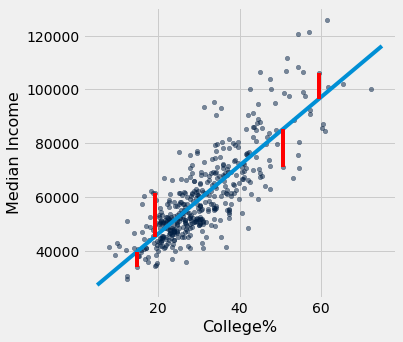

In [11]:
show_demographics_rmse(demographics_slope, demographics_intercept)

## Minimizing the RMSE


* To get estimates of y based on x, we can use any line we want.
* Every line has a root mean squared error of estimation.
* “Better” lines have smaller errors.


<font size='4pt'> The regression line is the unique straight line that minimizes the mean squared error of estimation among all straight lines.</font>


### Numerical Optimization ###

$$ \text{Goal: Minimize...     } \; \; \; \; \sqrt{ \text{Sum of all (observed $y$-values - predictions)}^2 }$$

$$ \text{New goal: minimize...    } \; \; \; \;  \text{Sum of all (observed $y$-values - predictions)}^2 $$

In [33]:
def demographics_mse(any_slope, any_intercept):
    x = demographics.column('College%')
    y = demographics.column('Median Income')
    fitted = any_slope*x + any_intercept
    return np.mean((y - fitted) ** 2)

In [34]:
demographics_mse(demographics_slope, demographics_intercept)

88332095.26861739

In [35]:
demographics_slope, demographics_intercept

(1270.70168946388, 20802.577766677925)

In [36]:
demographics_mse(1300, 25000)

114462317.54252873

In [37]:
demographics_mse(1000, 15000)

297100589.22068965

<font size='5pt'>
minimize(function) = value(s) that minimize function
    </font>

In [17]:
def f(x):
    return ((x-2)**2) + 3

Plot of $f(x) = (x-2)^2 + 3$:

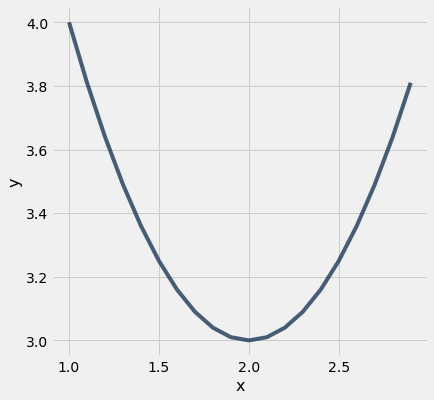

In [18]:
x = np.arange(1, 3, 0.1)
y = (x-2)**2 + 3
Table().with_columns('x', x, 'y', y).plot('x')

In [38]:
minimize(f)

1.9999999946252267

### Minimizing RMSE ###

<font size='3pt'>
demographics_mse(slope, intercept) = Mean Squared Error( line with given slope, intercept )
    </font>

In [39]:
minimize(demographics_mse)

array([ 1270.70168947, 20802.5777658 ])

In [40]:
demographics_slope, demographics_intercept

(1270.70168946388, 20802.577766677925)

### Nonlinear Regression ###

In [41]:
from IPython.display import HTML, display
display(HTML("<table><tr><td><img src='octopusbeak.png'></td><td><img src='octopus1.png'></td></tr></table>"))

,


First photo: 'Squid beak insight shifts chitosan composites up the pecking order', Chemistry World.

Second photo: Evaluating age in Octopus vulgaris: Estimation, validation and seasonal differences, Marine Ecology Progress Series 441:141-149.

In [44]:
octopus = Table.read_table('octopusbeakweight.csv').select('latWall', 'totWt')
                                                          
octopus


latWall,totWt
74,91
131,532
138,537
135,605
155,647
165,708
147,724
127,900
221,925
168,1074


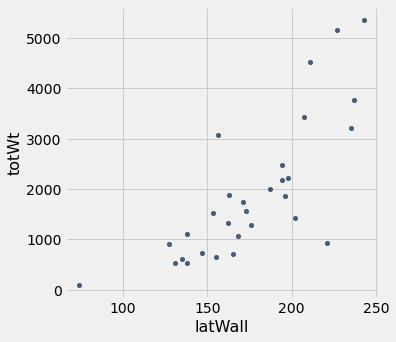

In [45]:
octopus.scatter('latWall', 'totWt')

### Finding a regression line via minimization:
1. Write a function with variables *slope* and *intercept* that calculates the root mean squared error obtained by estimating desired quantity using a line with given slope and intercept
2.  Use the minimize function to find the values of *slope* and *intercept* that minimize the function in 1.

In [46]:
def octopus_linear_rmse(any_slope, any_intercept):
    x = octopus.column('latWall')
    y = octopus.column('totWt')
    estimate = any_slope*x + any_intercept
    return np.mean((y - estimate) ** 2) ** 0.5

In [47]:
best_line = minimize(octopus_linear_rmse)
best_line

array([   29.85316988, -3237.26203665])

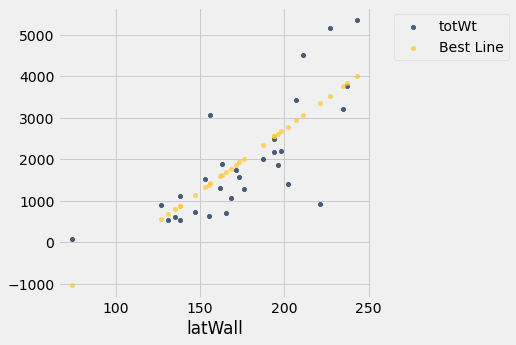

In [48]:
wall = octopus.column(0)

linear_fit = best_line.item(0)*wall + best_line.item(1)
octopus.with_column(
    'Best Line', linear_fit
).scatter(0)

**Quadratic Function**

$$
f(x) ~=~ ax^2 + bx + c
$$
for constants $a$, $b$, and $c$.



In [49]:
def octopus_quadratic_rmse(a, b, c):
    x = octopus.column('latWall')
    y = octopus.column('totWt')
    estimate = a*(x**2) + b*x + c
    return np.mean((y - estimate) ** 2) ** 0.5

In [50]:
best_quad = minimize(octopus_quadratic_rmse)
best_quad

array([ 8.32321577e-02, -3.95732473e-02, -7.68400440e+02])

### Best quadratic function: 
$$ f(x) = 0.083232 x^2 - .039573 x - .07684$$

In [51]:
# x =lateral wall increment count = 250
# Then predicted beak weight:

(best_quad.item(0))*(250**2) + best_quad.item(1)*250 + best_quad.item(2)

4423.716103337753

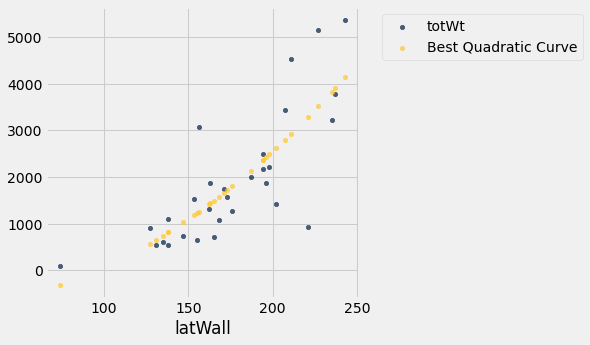

In [52]:
quad_fit = best_quad.item(0)*(wall**2) + best_quad.item(1)*wall + best_quad.item(2)

octopus.with_column('Best Quadratic Curve', quad_fit).scatter(0)

In [53]:
octopus_linear_rmse(best_line.item(0), best_line.item(1))

882.1162473293709

In [54]:
octopus_quadratic_rmse(best_quad.item(0), best_quad.item(1), best_quad.item(2))

830.6126298359936

<font color='green'> </font>